In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

Each event:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves

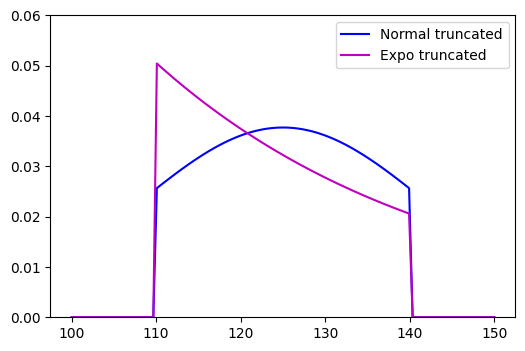

In [3]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.legend()
plt.show()

In [4]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [5]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

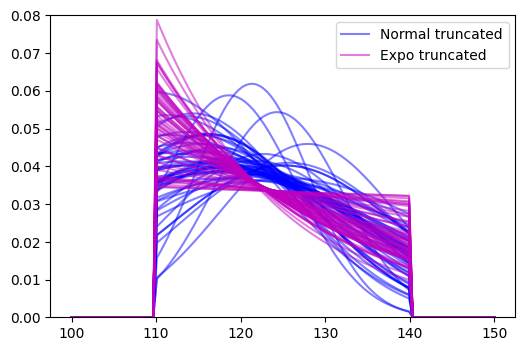

In [6]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.legend()
plt.show()

## Generate data

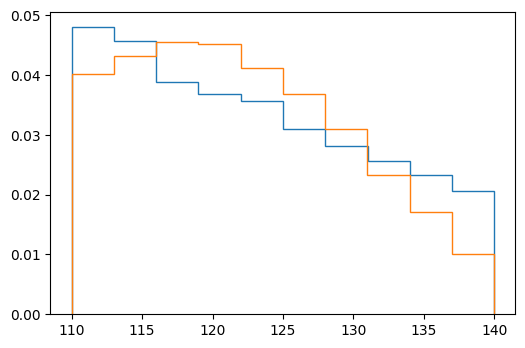

In [7]:
b=30
Lambda = 0.03
plt.hist(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=10000),histtype='step', density=1)
mu=118
sigma=12
plt.hist(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=10000),histtype='step', density=1)
plt.show()

In [73]:
b=30
Lambda = 0.06
mu=123
sigma=2
###################
data = []
p = [0.6,0.4]
np.random.seed(seed=0)
for i in range(5000):
    if np.random.binomial(1,p[0], size=1)[0]:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
    else:
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])

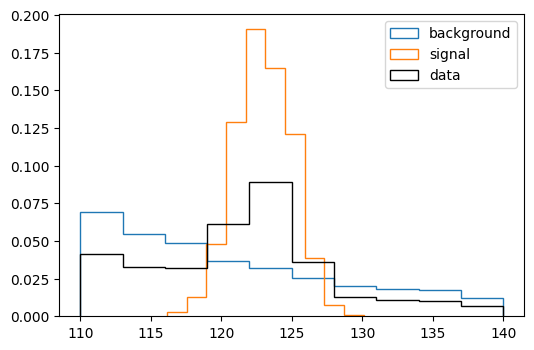

In [74]:
plt.hist([x[1] for x in data if x[2]==0],histtype='step', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.legend()
plt.show()

## Stan inference

Link to truncate: https://mc-stan.org/docs/stan-users-guide/truncation-censoring.html#truncation.section

As simple as:

model {

  y ~ normal(mu, sigma) $T[L,U]$;

}

In [135]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 array[N,2] real<lower=0> y;  // the 2 observables per event
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
     lp[1] = normal_lpdf(y[n,1] | mu, sigma)  + normal_lpdf(y[n,2] | mu, sigma);
     lp[2] = exponential_lpdf( y[n,1] | lambda0) + exponential_lpdf( y[n,2] | lambda0);
     target += log_mix(theta, lp);
                     //normal_lpdf(y[n,1] | mu, sigma)  + normal_lpdf(y[n,2] | mu, sigma),
                     //exponential_lpdf( y[n,1] | lambda) + exponential_lpdf( y[n,2] | lambda) );                                    
     };
}
"""

In [162]:
mu0 = 120
sigma0 = 6
mu1 = 10
sigma1 =5
mu2 = Lambda*0.7
sigma2 = Lambda*0.2       
t1 = 15
t2 = 15

In [163]:
passed_data = [[x[0], x[1]] for x in data]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2
          }

In [164]:
model = stan.build(my_model, data=my_data, random_seed=1);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_joaf_bw3/model_d2rwo4vk.stan', line 20, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [165]:
fit = model.sample(num_chains=4, num_samples=1000)


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3001/8000)
Sampling:  39% (3101/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3302/8000)
Samplin

In [166]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,lambda0,theta.1,theta.2
draws,,,,,,,,,,,,
0,-32927.239573,0.507242,0.163723,4.0,15.0,0.0,32932.906110,121.490413,6.378109,0.023907,0.996698,0.003302
1,-32927.899087,0.965103,0.168926,4.0,23.0,0.0,32930.448869,121.452020,6.463870,0.016358,0.996403,0.003597
2,-32924.824048,0.997296,0.161495,4.0,31.0,0.0,32925.449173,121.489144,6.494161,0.046679,0.997088,0.002912
3,-32927.627883,0.958670,0.183754,4.0,15.0,0.0,32931.918148,121.541146,6.356552,0.058828,0.997552,0.002448
4,-32927.430420,0.973231,0.163723,4.0,15.0,0.0,32927.680719,121.526997,6.380262,0.023635,0.996619,0.003381
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-32925.307786,0.540611,0.183754,2.0,7.0,0.0,32932.203063,121.558258,6.435727,0.054019,0.996641,0.003359
3996,-32929.080060,0.995161,0.163723,4.0,27.0,0.0,32930.457832,121.515557,6.414818,0.015366,0.997995,0.002005
3997,-32926.667322,0.947342,0.168926,5.0,31.0,0.0,32927.483872,121.433596,6.431324,0.029693,0.995759,0.004241


In [167]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,121.488,0.064,121.371,121.609,0.001,0.001,4477.0,2941.0,1.0
sigma,6.448,0.046,6.357,6.528,0.001,0.001,2212.0,2148.0,1.0
lambda0,0.041,0.012,0.018,0.064,0.000,0.000,1188.0,767.0,1.0
theta[0],0.997,0.001,0.996,0.998,0.000,0.000,2208.0,1813.0,1.0
theta[1],0.003,0.001,0.002,0.004,0.000,0.000,2208.0,1813.0,1.0


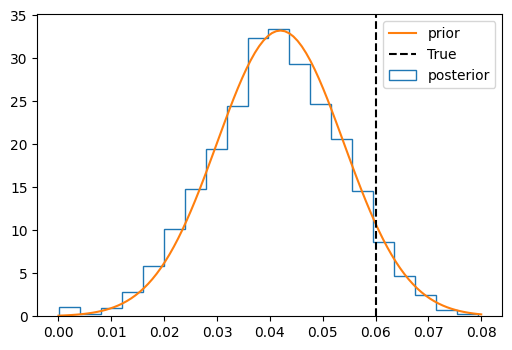

In [168]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.legend()
plt.show()

In [169]:
np.random.dirichlet([1,1], size=10)

array([[0.7577276 , 0.2422724 ],
       [0.4342261 , 0.5657739 ],
       [0.70122858, 0.29877142],
       [0.89142239, 0.10857761],
       [0.29644577, 0.70355423],
       [0.97872358, 0.02127642],
       [0.90474317, 0.09525683],
       [0.32695163, 0.67304837],
       [0.6369404 , 0.3630596 ],
       [0.88510831, 0.11489169]])

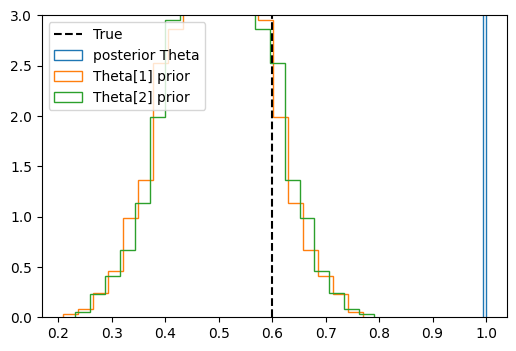

In [170]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.1'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=0.6, linestyle='dashed', color='black', label='True')
plt.ylim(0,3)
plt.legend()
plt.show()